# Can we predict if a Transit is due to a Brown Dwarf Star or a Planet? 

### An analysis for Data Scientists (and perhaps Amateur Astronomers)

So as to be transparent, I base the following analysis from my lecture notes and examples from the following Udemy courses: 

***Machine Learning in Python Level 1: Beginner*** by Hadelin de Ponteves and Kirill Eremenko

***Machine Learning Classification Bootcamp in Python*** by Dr. Ryan Ahmed, Ph.D., MBA 

***Python for Data Science and Machine Learning Bootcamp*** by Jose Portilla

as well as chunks of code gleaned from similar studies on Kaggle. Note this data set was aquired outside of these courses. The code here also has been modified from the original sources as it applies to this specific work, as well as to differentiate it from the course content.

First and foremost I want to state that my academic background *is* astrophysics. I did my undergraduate research in observing such planetary systems (using the *transit method*, mentioned next). However my opportunites to study planets in graduate school didn't pan out, and I left that field entirely behind to study galaxies and galaxy evolution, with almost no overlap in content (exception, studying molecular gas). It was only at one of my temparary teaching positions that I was able to help undergradute students do similar research projects and formally revisit this material (as well as that I cover this material in introductory astronomy for non-STEM student courses). It was fun to put this hat on again, if it was only brief in time, but gave me a fun idea to do some analysis.

Thus, I am acutely aware that this project is of little academic value to the field - but if you study this and find this is interesting - send me a message and let's write this up in a journal! This analysis is entirely for practicing my Data Science and Machine Learning skills, blemishes and all, so that people will consider hiring me to do such things with non-astronomy data.

## Crashcourse - Exoplanets:

It comes as a surprise to many that we actually do not directly image planets orbiting other stars all the often. In fact we only have ~60-70 confirmed images of exoplanets (stated on the website this data is sourced from). We detect planets around other stars primary through indirect methods. 

The ***transit method*** looks for eclipses of the planet passinging in front of the parent star. It is important to note here that we still are not directly imaging the planet NOR are we seeing this eclipse in the way we see solar/lunar/Venus/etc. eclipses on Earth. We simply measure the drop in brightness of the parent star. Through physics, we can turn that drop into the **radius of the planet** $R_{\rm planet}$ when we also know information about the star (which is another discussion, but for this study assume that is usually the case for these systems). The frequency with which these transits occur tell us the **period** $P$, and through a relationship called Kepler's 3rd Law, (${\rm Period})^2 \propto ({\rm Semi-Major \  Axis})^3$, we can determine the **semi-major axis** $a$. The semi-major axis is, for nearly circular systems, approximately the average distance between the planet and the star (elliptical systems this relates to the longest half-axis, not important for this analysis).

***Radial velocity*** (or ***RV***) method uses the doppler method (through spectral features (like emission/absortion lines) in the parent star's spectra) to discover planets due to the gravitational *wobble* of a planetary system around the parent star. This method also returns the **period** (and thus semi-major axis) when observed more than once, but this wobble gives the **mass of the planet** $M_{\rm planet}$ - well kind of. This method can not on it's own identify the inclination (parameterized by angle $i$), and thus this method only gives $M_{\rm planet} \sin i$ when $i$ can not be determined.

Transits alone cannot identify if a planet that is being observed is a planet or a brown dwarf star, and this is because the mass of the planet cannot be estimated through this process. This poses a problem as the large majority of the exoplanets that have been discovered *only* have transit confirmations.

Moreover, small observatories can and regularly observe transits - which provide really powerful first observational experiences for students and amateur astronomers. Sometimes those communities will try to observe the radial velocity of the parent star to estimate the mass of the planet, however 1. that precision required is much higher than transits and 2. spectrographs are additional equipment that fewer groups have access to. A quick method for ruling out Brown Dwarf Stars for low precision is that Brown Dwarf Stars are usually massive enough to give a signal when a planet otherwise would not. 

It would be exiting if machine learning methods could perhaps *estimate* a probability that a transit if given just data that a transit has access to.

Properties of the Parent Star:
Most star systems of interest are cataloged, so the properties of the star (surface temperature, luminosity or brightness, mass, radius, surface gravity,...). Some of these quantities are connected through relationships in physics (Stefan-Boltzmann Law: ${\rm Luminosity} \propto {\rm Radius}^2 {\rm Temperature}^4$, and a mass-luminsoity relationship: ${\rm Luminosity} \propto {\rm Mass}^{\alpha}$) so it's unwise to consider *every* parameter available. So an educated and conservative initial guess will be: *Mass, Surface Temperature*

Properties of the Planet From A Transit: *Period* - how frequently this happens, *Radius* - from the transit depth of the observation

## The dataset

Parent Data: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars

Data Cleaned and Classified In *exoplanet_analysis_cleaning_ER.ipynb*, here is the summary:

First, we select only systems that have **BOTH** a transit observation and a radial velocity measurement.

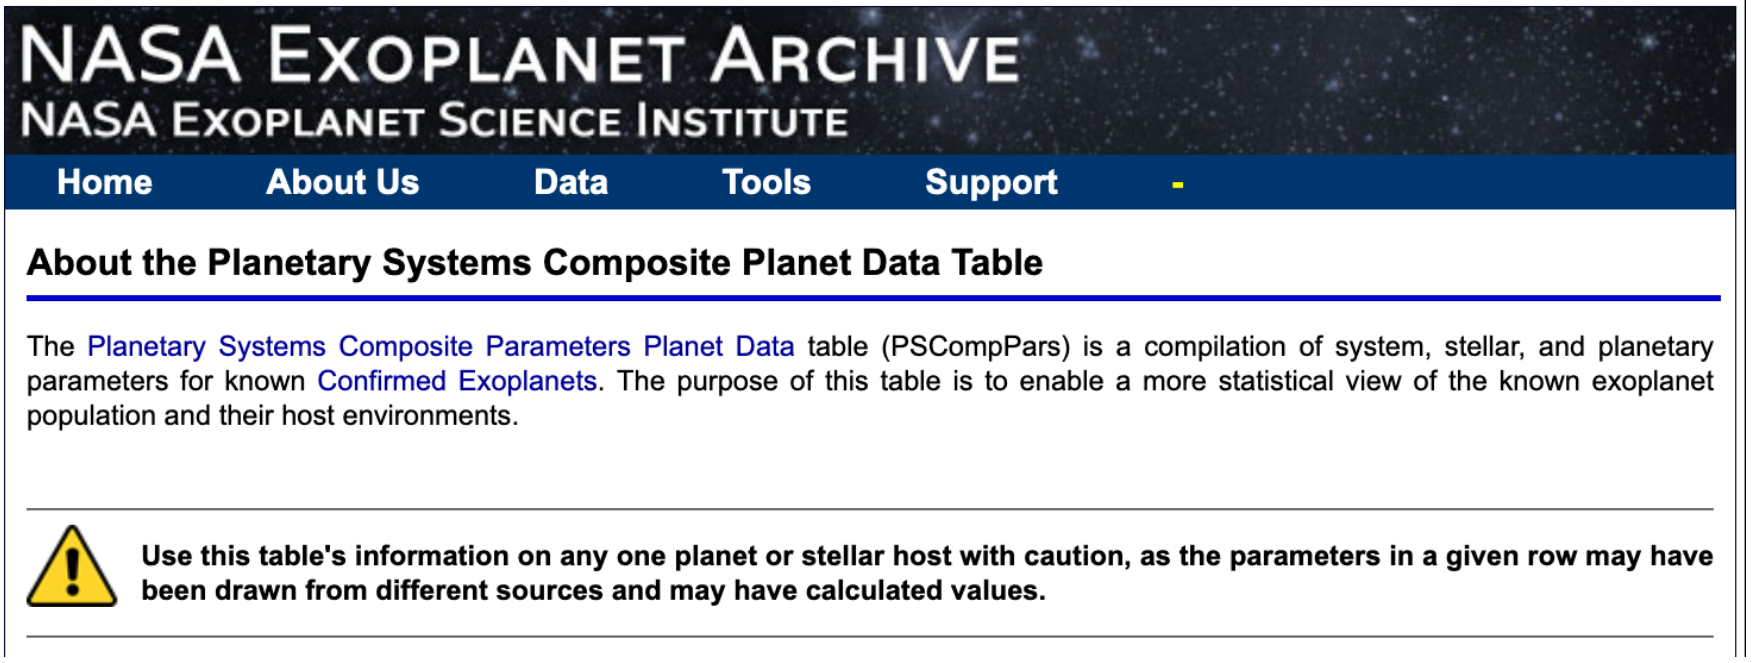

The data we are starting with is an already slimmed down library of observed exoplanets. In the parent data repository, every planet listed in the table could have several entries that measure different sets of parameters in different (perhaps inconsistent) ways. The table we are using is essentially a flat version of this, collapsing all of the data given to one entry per target, but it is removing data that is double entered - regardless of agreement. Thus, there is a lot of build in uncertainty to just using this table. To do a *real* scientific analysis would require a proper collapsing of all of these enteries, justifying why you might pick one study over another for double listed data, etc. - something that is far beyond the scope (or want) of this project.

### Create Density Classes
https://arxiv.org/abs/1612.03556

The classes in the previous image are not shared in an easily obtainable way. I rather decided to do coarse classifications (at least for now) to identify planets by their densities. This also allows us to remove objects like Brown Dwarf Stars ('failed' stars) that might present themselves here.

Taking their proposed classifications, and stretching the edges since they don't overlap.

Ice/gas giant: $\rho < \approx 2.85$ $\frac{g}{cm^3}$ 

Iron/Rock: $ 2.85 \frac{g}{cm^3} < \approx \rho < \approx 19.2 \frac{g}{cm^3}$

Degenerate (Brown Dwarf): $\rho > \approx 19.2 \frac{g}{cm^3}$ - failed stars  

Note, Brown Dwarfs also need a radius ~> 7 times that of Earth - so I will include that classification for Brown Dwarfs, and say otherwise if the densities are higher than $ 2.85 \frac{g}{cm^3} $ they are terrestrial. This is a crude solution.

## Importing the dataset 
#### Based On *Machine Learning in Python Level 1: Beginner*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
df = pd.read_csv('exoplanet_cleaned.csv')

In [3]:
df['pl_class'] = df['pl_class2'].iloc[:].values
df = df.drop(['pl_class2'],axis=1)

### Explore Data 

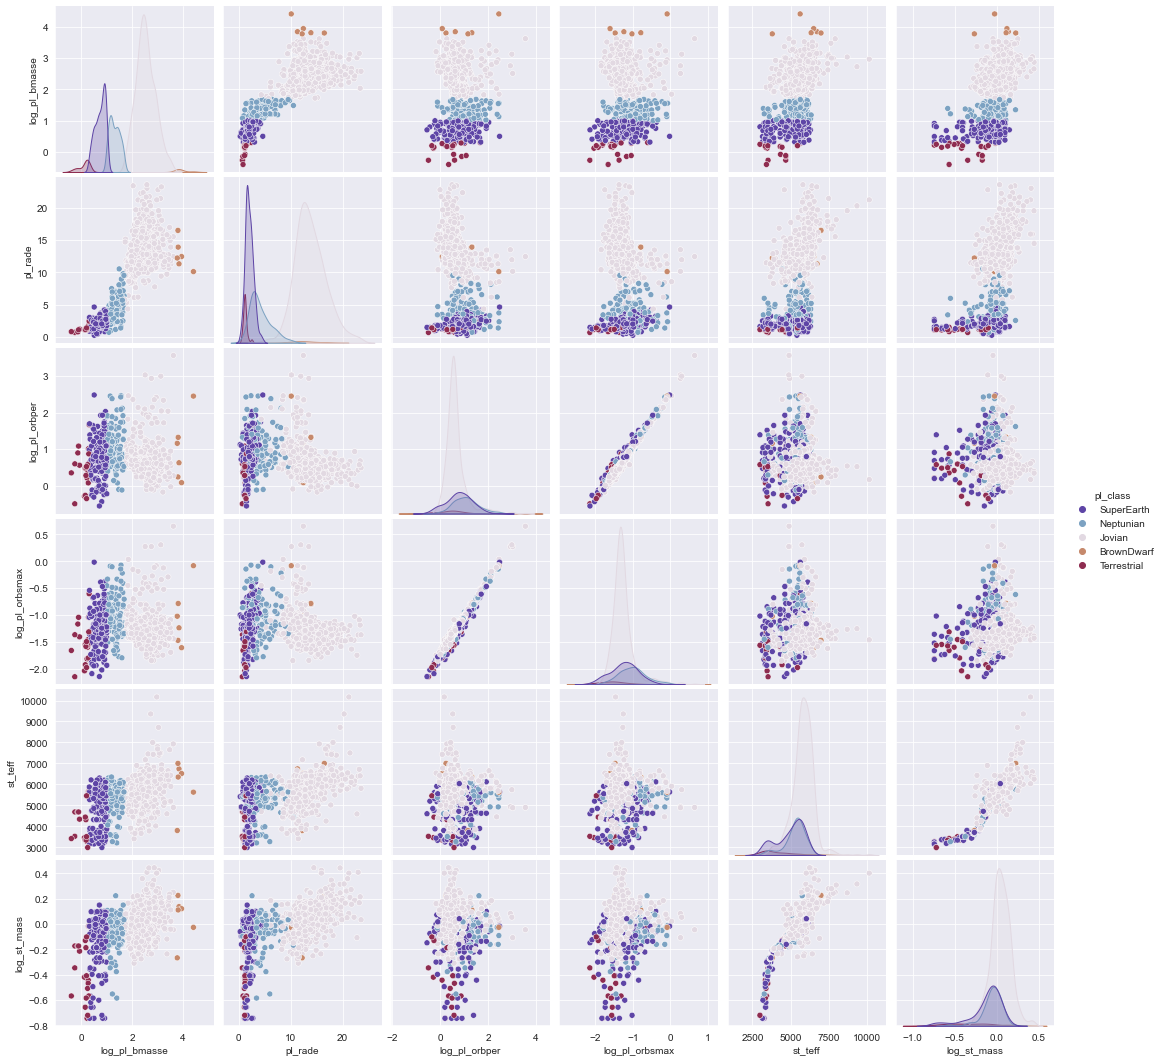

In [4]:
sns.pairplot(df.drop(['log_pl_densitye'],axis=1),palette='twilight_shifted',hue='pl_class')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


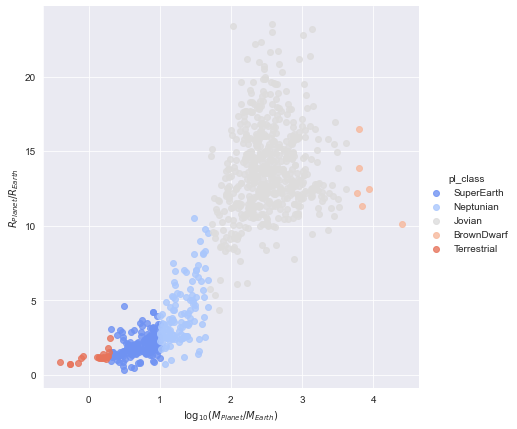

In [5]:
sns.set_style('darkgrid')
ax = sns.lmplot(x = 'log_pl_bmasse',y = 'pl_rade',data=df, hue='pl_class',
           palette='coolwarm',size=6,aspect=1,fit_reg=False)
ax.set(xlabel='$\log_{10} (M_{Planet} / M_{Earth})$', ylabel='$R_{Planet} / R_{Earth}$')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


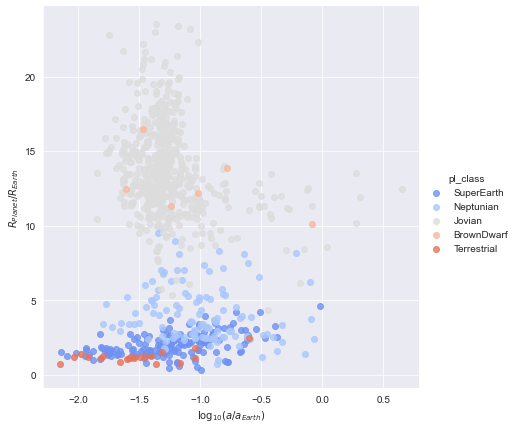

In [6]:
sns.set_style('darkgrid')
ax = sns.lmplot(x = 'log_pl_orbsmax',y = 'pl_rade',data=df, hue='pl_class',
           palette='coolwarm',size=6,aspect=1,fit_reg=False)
ax.set(xlabel='$\log_{10} (a / a_{Earth})$', ylabel='$R_{Planet} / R_{Earth}$')

In [7]:
df.head(5)

,pl_name,log_pl_bmasse,pl_rade,log_pl_densitye,log_pl_orbper,log_pl_orbsmax,st_teff,log_st_mass,pl_class
0,55 Cnc e,0.902547,1.875,-0.041396,-0.132799,-1.811353,5172.0,-0.040959,SuperEarth
1,AU Mic b,1.303628,4.070,-0.650094,0.927524,-1.190440,3588.0,-0.301030,Neptunian
2,AU Mic c,0.982271,3.240,-0.674303,1.275518,-0.958213,3700.0,-0.301030,SuperEarth
3,BD+20 594 b,1.347293,2.578,-0.011495,1.619985,-0.617983,5766.0,0.222716,Neptunian
4,CoRoT-1 b,2.515012,16.700,-1.278076,0.178676,-1.560352,5950.0,-0.022276,Jovian


In [8]:
df_BDtest = df.copy()

## Slim the dataset down

1. Transits are likely only to occur around main sequence stars - which in short are stars that have not begun their late-stage life evolution (among the first being a red giant). The red giant phase would presumably destroy, at least, the inner planets and the majority of our transits occur close-in.

2. Main sequence stars have a mass-luminosity relationship (mentioned earlier ${\rm Luminosity} \propto {\rm Mass}^{\alpha}$) and all stars follow the Stefan-Boltzmann Law (also mentioned earlier, ${\rm Luminosity} \propto {\rm Radius}^2 {\rm Temperature}^4$)

3. Density was calculated using mass and radius, and we want to only include **transit specific** estimates.

So we will drop, everything *except* 

1. planet radius (from transit depth)

2. planet period (from frequency of transits)

3. effective temperature of the star (roughly classifies the type of star)

In [9]:
df_BDtest = df_BDtest.drop(['pl_name', 'log_pl_bmasse','log_pl_densitye','log_pl_orbsmax','log_st_mass'],axis=1)

In [10]:
df_BDtest 

,pl_rade,log_pl_orbper,st_teff,pl_class
0,1.875,-0.132799,5172.0,SuperEarth
1,4.070,0.927524,3588.0,Neptunian
2,3.240,1.275518,3700.0,SuperEarth
3,2.578,1.619985,5766.0,Neptunian
4,16.700,0.178676,5950.0,Jovian
...,...,...,...,...
850,14.011,0.615432,6397.0,Jovian
851,12.780,0.621981,5430.0,Jovian
852,23.203,0.575765,6720.0,Jovian
853,15.390,0.456995,6250.0,Jovian


In [11]:
df_BDtest.describe()

,pl_rade,log_pl_orbper,st_teff
count,855.000000,855.000000,855.000000
mean,9.836489,0.724791,5515.231661
std,5.879267,0.507883,860.615529
min,0.296000,-0.552339,2988.000000
25%,3.048500,0.446849,5151.000000
50%,11.545000,0.607031,5640.000000
75%,14.258000,0.954785,6052.500000
max,23.539000,3.562293,10170.000000


In [12]:
df.count()

pl_name            855
log_pl_bmasse      855
pl_rade            855
log_pl_densitye    855
log_pl_orbper      855
log_pl_orbsmax     855
st_teff            855
log_st_mass        855
pl_class           855
dtype: int64

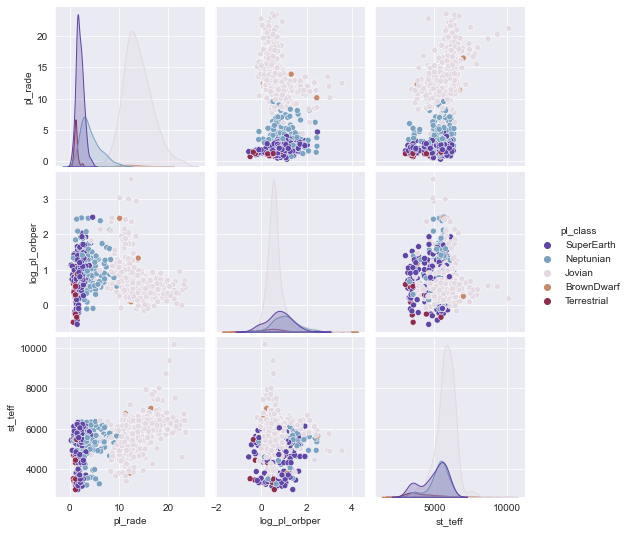

In [13]:
sns.pairplot(df_BDtest,palette='twilight_shifted',hue='pl_class')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


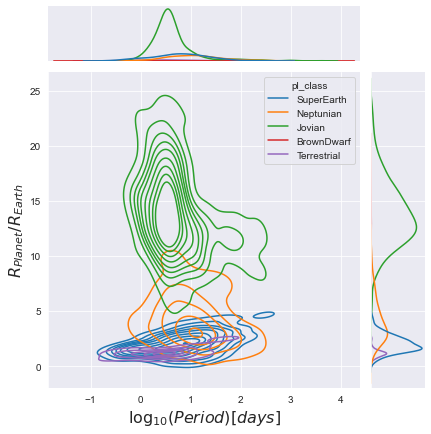

In [14]:
jp = sns.jointplot(x='log_pl_orbper',y='pl_rade',data=df_BDtest,kind='kde', hue='pl_class')
jp.set_axis_labels('$\log_{10} (Period) [days]$', '$R_{Planet} / R_{Earth}$', fontsize=16)

As expected, Jovian (gas giants) are typically larger than the Terrestrials planets. The Terrestrial planets seem to come in two sizes, about the size of the Earth and 10-15 times the size of the Earth. Brown Dwarf Stars are big like Jovian planets, however they are not the largest. Shorter periods mean the planet is close to the star (Kepler's 3rd Law) - so the Brown Dwarfs also seem to be at approximately Earth distances from the star they orbit.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


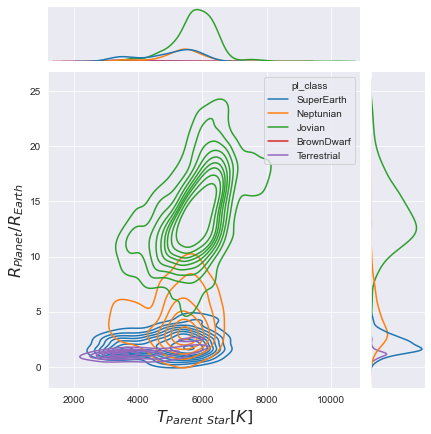

In [15]:
jp = sns.jointplot(x='st_teff',y='pl_rade',data=df_BDtest,kind='kde', hue='pl_class')
jp.set_axis_labels('$T_{Parent \ Star} [K]$', '$R_{Planet} / R_{Earth}$', fontsize=16)

<AxesSubplot:>

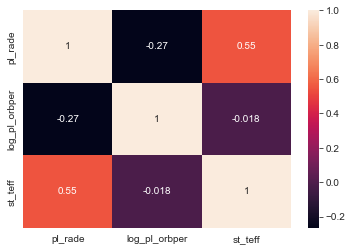

In [16]:
sns.heatmap(df_BDtest.corr(), annot=True)

In [17]:
df_BDtest[df_BDtest['pl_class'] == 'BrownDwarf'].count()

pl_rade          6
log_pl_orbper    6
st_teff          6
pl_class         6
dtype: int64

In [18]:
df_BDtest.count()

pl_rade          855
log_pl_orbper    855
st_teff          855
pl_class         855
dtype: int64

In [19]:
print(100.*14./855.)

1.6374269005847952


Only ~2% of the sample are classified as Brown Dwarf Stars. So our initial interpretation is that Brown Dwarf stars are not a huge contamination issue.

# Logistic Regression

### Creating the Training Set and the Test Set, Feature Scaling
#### Based On *Machine Learning in Python Level 1: Beginner*

In [20]:
X = df_BDtest.iloc[:, 1:-1].values
y = df_BDtest.iloc[:, -1].values

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [22]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train) #rescaled - note this also will allow us to scale the test set later
#we do NOT want to scale the test set separately OR with the training set

### Building/Training the model
#### Based On *Machine Learning in Python Level 1: Beginner*

In [23]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state = 0)

In [24]:
model.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [25]:
y_pred_log = model.predict(sc.transform(X_test))
#y_pred = model.predict(X_test)

### Confusion Matrix & Accuracy

#### Based On *Python for Data Science and Machine Learning Bootcamp* as well as *Machine Learning in Python Level 1: Beginner*


In [26]:
from sklearn.metrics import confusion_matrix
cm_log=confusion_matrix(y_test,y_pred_log)

In [27]:
cm_log

array([[103,   3,   3,   0],
       [ 18,   1,   4,   0],
       [ 26,   2,   7,   0],
       [  0,   0,   4,   0]])

<AxesSubplot:>

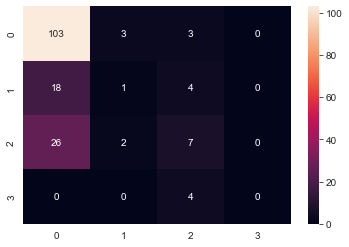

In [28]:
sns.heatmap(cm_log, annot=True, fmt="d")

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

      Jovian       0.70      0.94      0.80       109
   Neptunian       0.17      0.04      0.07        23
  SuperEarth       0.39      0.20      0.26        35
 Terrestrial       0.00      0.00      0.00         4

    accuracy                           0.65       171
   macro avg       0.31      0.30      0.28       171
weighted avg       0.55      0.65      0.58       171



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.metrics import accuracy_score
print('Accuracy Score, Logistic Regression:', accuracy_score(y_test,y_pred_log))

Accuracy Score, Logistic Regression: 0.6491228070175439


# K-Nearest Neighbor
#### Based On *Machine Learning Classification Bootcamp in Python*

The train/test split and scaling from the Logistic Regression can be used here as well.

In [31]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [32]:
y_pred_knn = classifier.predict(sc.transform(X_test))

In [33]:
#from sklearn.metrics import confusion_matrix, classification_report
cm_knn = confusion_matrix(y_test, y_pred_knn)

<AxesSubplot:>

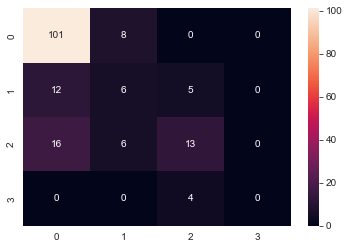

In [34]:
sns.heatmap(cm_knn, annot=True, fmt="d")

In [35]:
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

      Jovian       0.78      0.93      0.85       109
   Neptunian       0.30      0.26      0.28        23
  SuperEarth       0.59      0.37      0.46        35
 Terrestrial       0.00      0.00      0.00         4

    accuracy                           0.70       171
   macro avg       0.42      0.39      0.40       171
weighted avg       0.66      0.70      0.67       171



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
#from sklearn.metrics import accuracy_score
print('Accuracy Score, KNN:', accuracy_score(y_test,y_pred_knn))

Accuracy Score, KNN: 0.7017543859649122


# Support Vector Machines
#### Based On *Machine Learning Classification Bootcamp in Python*

The train/test split and scaling from the Logistic Regression can be used here as well.

In [37]:
from sklearn.svm import SVC 
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [38]:
y_pred_svm = svc_model.predict(sc.transform(X_test))

cm_svm = confusion_matrix(y_test, y_pred_svm)

<AxesSubplot:>

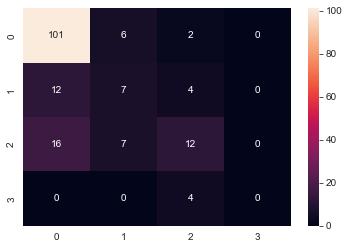

In [39]:
sns.heatmap(cm_svm, annot=True, fmt="d")

In [40]:
#from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

      Jovian       0.78      0.93      0.85       109
   Neptunian       0.35      0.30      0.33        23
  SuperEarth       0.55      0.34      0.42        35
 Terrestrial       0.00      0.00      0.00         4

    accuracy                           0.70       171
   macro avg       0.42      0.39      0.40       171
weighted avg       0.66      0.70      0.67       171



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
#from sklearn.metrics import accuracy_score
print('Accuracy Score, SVM:', accuracy_score(y_test,y_pred_svm))

Accuracy Score, SVM: 0.7017543859649122


# Conclusions & Discussion
## Can you predict if your transit is a Brown Drawf or a Planet?

In [42]:
print('Accuracy Score, LR :         ', accuracy_score(y_test,y_pred_log))
print('Accuracy Score, KNN:         ', accuracy_score(y_test,y_pred_knn))
print('Accuracy Score, SVM:         ', accuracy_score(y_test,y_pred_svm))

Accuracy Score, LR :          0.6491228070175439
Accuracy Score, KNN:          0.7017543859649122
Accuracy Score, SVM:          0.7017543859649122


These accuracy scores are misleading - because in every case above, **NONE of the models accurately predicted the Brown Dwarf accurately a single time**. The models also struggled to classify Jovian versus Terrestrial planet with a meaningful accuracy. This is extremely concerning as the classification scheme is extremely crude - only 3 classes. 

### Why can't we tell the difference between Terrestrial and Jovian Planets?

<AxesSubplot:xlabel='pl_rade', ylabel='Count'>

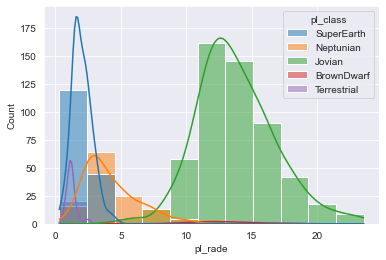

In [43]:
sns.histplot(data=df_BDtest, x='pl_rade', kde=True, hue='pl_class')

### Terrestrial planets seem to have two populations - one that is smaller than the Jovians, and one that overlaps. Thus it is easy to confuse large radius planets (ignoring other variables).

<AxesSubplot:>

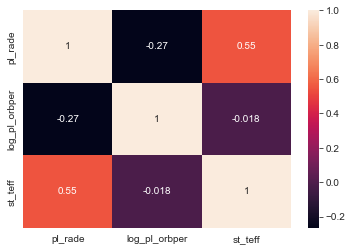

In [44]:
sns.heatmap(df_BDtest.corr(), annot=True)

<AxesSubplot:xlabel='st_teff', ylabel='Count'>

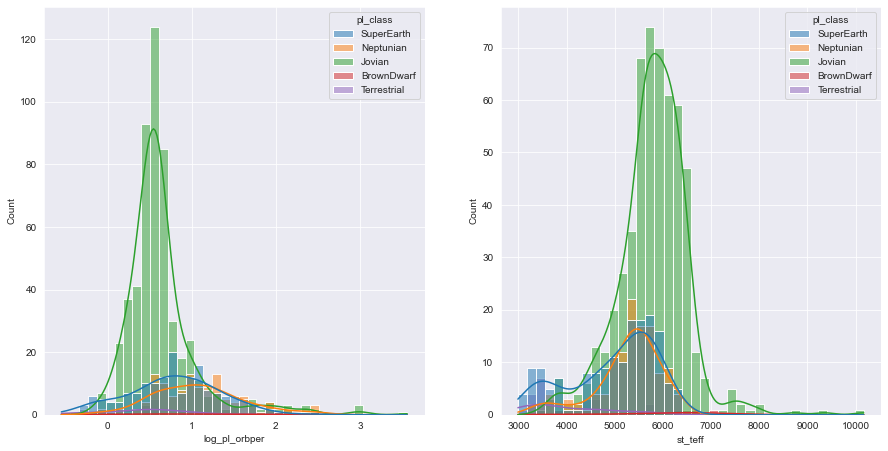

In [45]:
fig, ax =plt.subplots(1,2, figsize=(15, 7.5))
sns.histplot(data=df_BDtest, x='log_pl_orbper', kde=True, hue='pl_class', ax=ax[0])
sns.histplot(data=df_BDtest, x='st_teff', kde=True, hue='pl_class', ax=ax[1])

### Planet classification also does not appear to correlate with the orbital period (through Kepler's 3rd Law, essentially how far away from the parent star), nor does it correlate with the parent star's properties. Thus these variables have fairly weak predictive use.

# Why can't we find the Brown Dwarfs? - Add more BD!

The database we took this data from is entirely of targets that are known to be, or candidates to be, **planets** and NOT brown dwarfs. Thus we do not expect there to be any/many brown dwarfs, and consistently we find a contamination of only ~1-2%. 

Let's add a Transit Brown Dwarf library: https://www.theroncarmichael.com/browndwarfs

(data also cleaned in Data Cleaned and Classified In *exoplanet_analysis_cleaning_ER.ipynb*)

Since these are *all* classified as Brown Dwarfs already, there will be no need to otherwise classify them using density.

In [46]:
bd = pd.read_csv('browndwarf_cleaned.csv')

In [47]:
bd['pl_class'] = bd['pl_class2'].iloc[:].values
bd = bd.drop(['pl_class2'],axis=1)

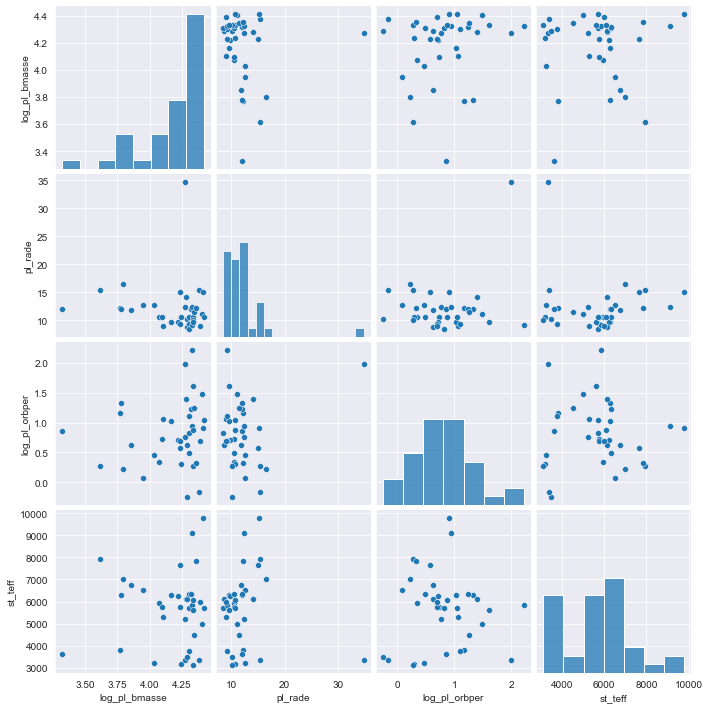

In [48]:
sns.pairplot(bd.drop(['log_pl_densitye'],axis=1),palette='twilight_shifted')#,hue='pl_class')

In [49]:
bd_cols = bd.columns.values

In [50]:
bd_cols

array(['pl_name', 'log_pl_bmasse', 'pl_rade', 'log_pl_densitye',
       'log_pl_orbper', 'st_teff', 'pl_class'], dtype=object)

Since BD dataset has fewer data, let's snip extras in the parent set before we combine

In [51]:
df_c = df.copy()
df_c = df_c.drop(['log_pl_orbsmax','log_st_mass'],axis=1)

In [52]:
df_moreBD = pd.concat([df_c,bd], ignore_index=True)

In [53]:
df_moreBD

,pl_name,log_pl_bmasse,pl_rade,log_pl_densitye,log_pl_orbper,st_teff,pl_class
0,55 Cnc e,0.902547,1.875000,-0.041396,-0.132799,5172.0,SuperEarth
1,AU Mic b,1.303628,4.070000,-0.650094,0.927524,3588.0,Neptunian
2,AU Mic c,0.982271,3.240000,-0.674303,1.275518,3700.0,SuperEarth
3,BD+20 594 b,1.347293,2.578000,-0.011495,1.619985,5766.0,Neptunian
4,CoRoT-1 b,2.515012,16.700000,-1.278076,0.178676,5950.0,Jovian
...,...,...,...,...,...,...,...
887,NGTS-7Ab,4.380247,15.468282,0.686982,-0.154902,3359.0,BrownDwarf
888,TOI-148b,4.389354,9.079209,1.390272,0.690196,5990.0,BrownDwarf
889,KOI-189b,4.407556,11.096811,1.147023,1.482874,4973.0,BrownDwarf
890,TOI-587b,4.411321,15.132015,0.746692,0.903090,9800.0,BrownDwarf


In [54]:
print('Percentage of Sample in BD =',100*df_moreBD[df_moreBD['pl_class'] == 'BrownDwarf']['pl_class'].count() / df_moreBD['pl_class'].count(), '%')

Percentage of Sample in BD = 4.820627802690583 %


# A few percent increase from 1.6% to 5.7%

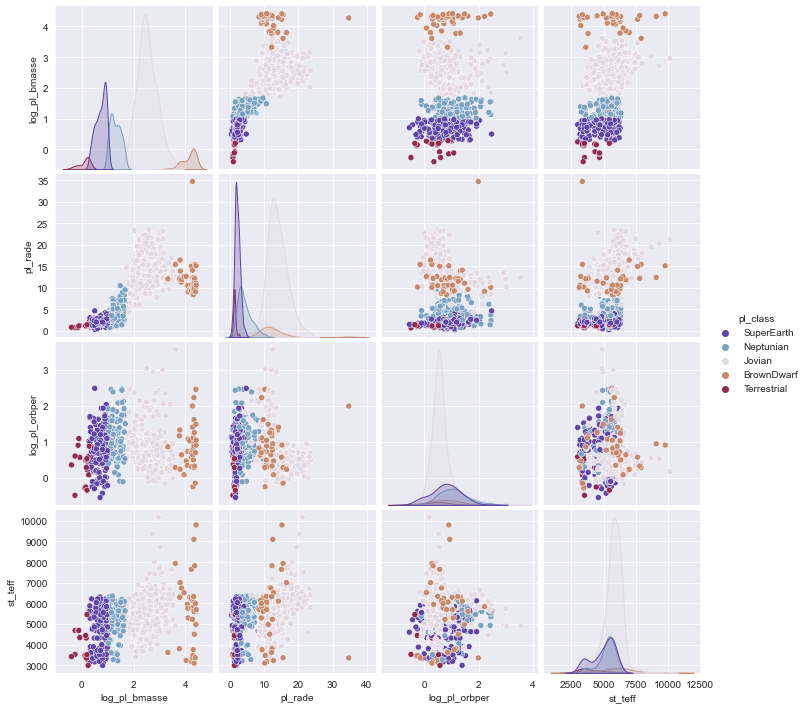

In [55]:
sns.pairplot(df_moreBD.drop(['log_pl_densitye'],axis=1),palette='twilight_shifted',hue='pl_class')

<AxesSubplot:xlabel='st_teff', ylabel='Count'>

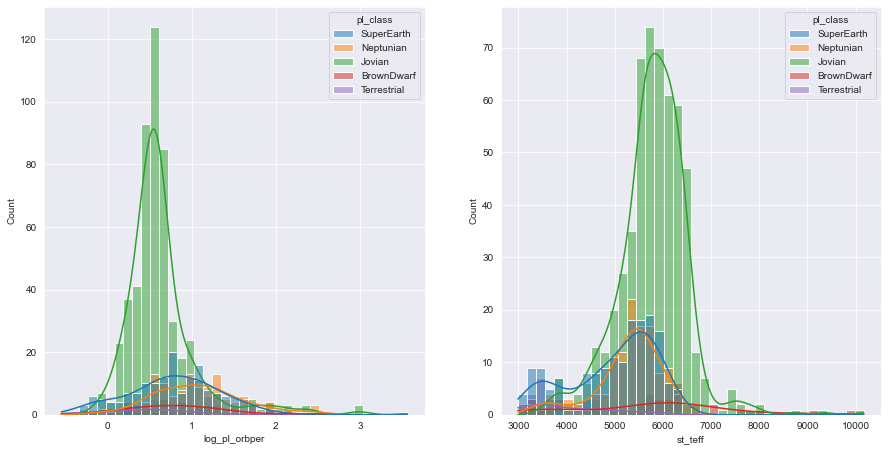

In [56]:
fig, ax =plt.subplots(1,2, figsize=(15, 7.5))
sns.histplot(data=df_moreBD, x='log_pl_orbper', kde=True, hue='pl_class', ax=ax[0])
sns.histplot(data=df_moreBD, x='st_teff', kde=True, hue='pl_class', ax=ax[1])

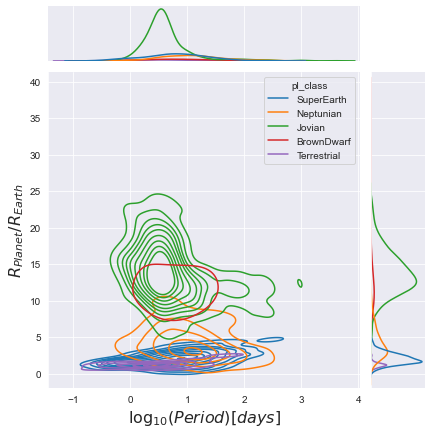

In [57]:
jp = sns.jointplot(x='log_pl_orbper',y='pl_rade',data=df_moreBD,kind='kde', hue='pl_class')
jp.set_axis_labels('$\log_{10} (Period) [days]$', '$R_{Planet} / R_{Earth}$', fontsize=16)

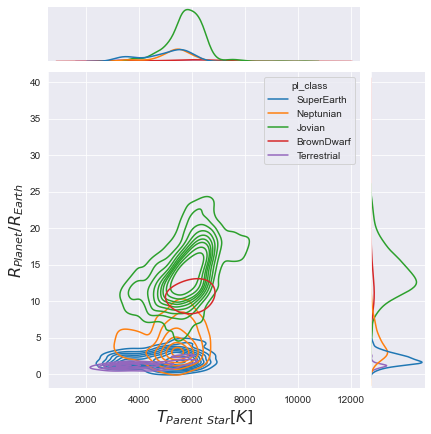

In [58]:
jp = sns.jointplot(x='st_teff',y='pl_rade',data=df_moreBD,kind='kde', hue='pl_class')
jp.set_axis_labels('$T_{Parent \ Star} [K]$', '$R_{Planet} / R_{Earth}$', fontsize=16)

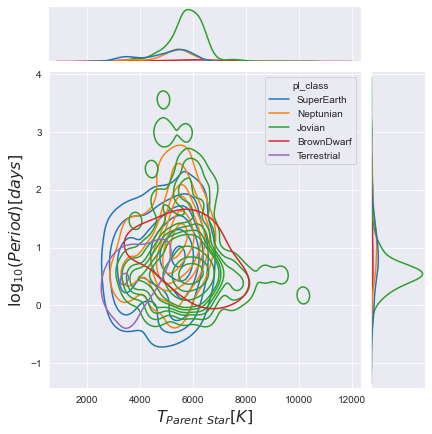

In [59]:
jp = sns.jointplot(x='st_teff',y='log_pl_orbper',data=df_moreBD,kind='kde', hue='pl_class')
jp.set_axis_labels('$T_{Parent \ Star} [K]$', '$\log_{10} (Period) [days]$', fontsize=16)

# Repeat Analysis with new data added

In [60]:
df_moreBD_d = df_moreBD.drop(['pl_name','log_pl_bmasse','log_pl_densitye'],axis=1)

In [61]:
df_moreBD_d.head(2)

,pl_rade,log_pl_orbper,st_teff,pl_class
0,1.875,-0.132799,5172.0,SuperEarth
1,4.070,0.927524,3588.0,Neptunian


In [62]:
## Train/test Split
X = df_moreBD_d.iloc[:, 0:-1].values
y = df_moreBD_d.iloc[:, -1].values

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [64]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train) 

# Add Various ML Methods already attempted

### Logistic Regression

In [65]:
#from sklearn.linear_model import LogisticRegression
model_log = LogisticRegression(random_state = 0)
model_log.fit(X_train,y_train)
y_pred_log = model_log.predict(sc.transform(X_test))
#from sklearn.metrics import confusion_matrix
cm_log=confusion_matrix(y_test,y_pred_log)

Heatmap: Logistic Regression


<AxesSubplot:>

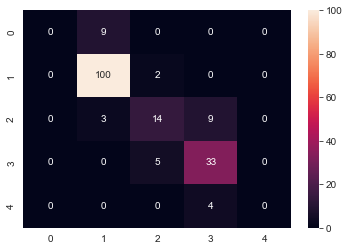

In [66]:
print('Heatmap: Logistic Regression')
sns.heatmap(cm_log, annot=True, fmt="d")

In [67]:
#from sklearn.metrics import classification_report
print('Classification Report: Logistic Regression')
print(classification_report(y_test,y_pred_log))

Classification Report: Logistic Regression
              precision    recall  f1-score   support

  BrownDwarf       0.00      0.00      0.00         9
      Jovian       0.89      0.98      0.93       102
   Neptunian       0.67      0.54      0.60        26
  SuperEarth       0.72      0.87      0.79        38
 Terrestrial       0.00      0.00      0.00         4

    accuracy                           0.82       179
   macro avg       0.46      0.48      0.46       179
weighted avg       0.76      0.82      0.79       179



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### K-Nearest Neighbor

In [68]:
#from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
y_pred_knn = classifier.predict(sc.transform(X_test))
#from sklearn.metrics import confusion_matrix, classification_report
cm_knn = confusion_matrix(y_test, y_pred_knn)

Heatmap: KNN


<AxesSubplot:>

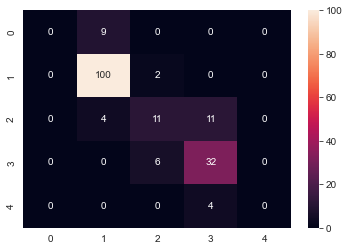

In [69]:
print('Heatmap: KNN')
sns.heatmap(cm_knn, annot=True, fmt="d")

In [70]:
#from sklearn.metrics import classification_report
print('Classification Report: KNN')
print(classification_report(y_test,y_pred_knn))

Classification Report: KNN
              precision    recall  f1-score   support

  BrownDwarf       0.00      0.00      0.00         9
      Jovian       0.88      0.98      0.93       102
   Neptunian       0.58      0.42      0.49        26
  SuperEarth       0.68      0.84      0.75        38
 Terrestrial       0.00      0.00      0.00         4

    accuracy                           0.80       179
   macro avg       0.43      0.45      0.43       179
weighted avg       0.73      0.80      0.76       179



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Support Vector Machines

In [71]:
#from sklearn.svm import SVC 
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svm = svc_model.predict(sc.transform(X_test))
cm_svm = confusion_matrix(y_test, y_pred_svm)

Heatmap: SVM


<AxesSubplot:>

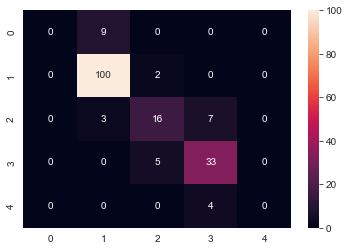

In [72]:
print('Heatmap: SVM')
sns.heatmap(cm_svm, annot=True, fmt="d")

In [73]:
#from sklearn.metrics import classification_report
print('Classification Report: SVM')
print(classification_report(y_test,y_pred_svm))

Classification Report: SVM
              precision    recall  f1-score   support

  BrownDwarf       0.00      0.00      0.00         9
      Jovian       0.89      0.98      0.93       102
   Neptunian       0.70      0.62      0.65        26
  SuperEarth       0.75      0.87      0.80        38
 Terrestrial       0.00      0.00      0.00         4

    accuracy                           0.83       179
   macro avg       0.47      0.49      0.48       179
weighted avg       0.77      0.83      0.80       179



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusions & Discussion - Part 2 with More Brown Dwarfs
## Can you predict if your transit is a Brown Drawf or a Planet?

## Compare Accuracy Scores

In [74]:
print('Accuracy Score, LR :         ', accuracy_score(y_test,y_pred_log))
print('Accuracy Score, KNN:         ', accuracy_score(y_test,y_pred_knn))
print('Accuracy Score, SVM:         ', accuracy_score(y_test,y_pred_svm))

Accuracy Score, LR :          0.8212290502793296
Accuracy Score, KNN:          0.7988826815642458
Accuracy Score, SVM:          0.8324022346368715


These accuracy scores are *still* misleading - because SVM is the **only** model with a postive Brown Dwarf predicition, and that prediction is just one. 

Surprisingly, adding more Brown Dwarf stars *does* increase the precision of the other planet classifications.

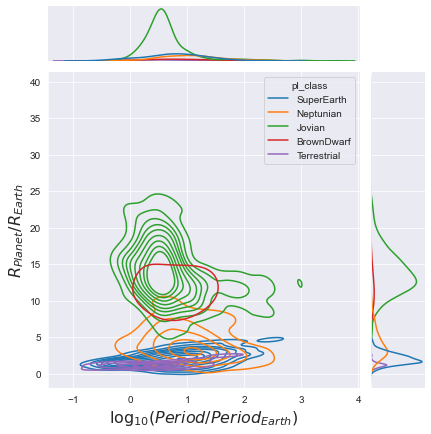

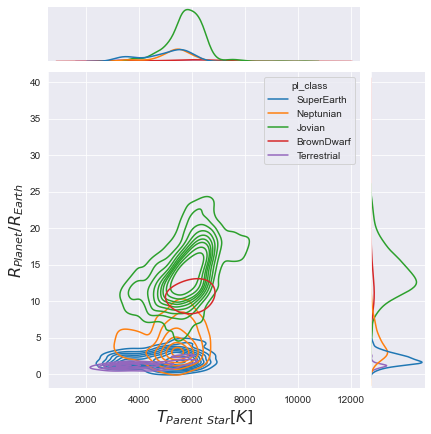

In [75]:
#fig, (jp1, jp2) = plt.subplots(1, 2)
jp1 = sns.jointplot(x='log_pl_orbper',y='pl_rade',data=df_moreBD,kind='kde', hue='pl_class')
jp1.set_axis_labels('$\log_{10} (Period / Period_{Earth})$', '$R_{Planet} / R_{Earth}$', fontsize=16)

jp2 = sns.jointplot(x='st_teff',y='pl_rade',data=df_moreBD,kind='kde', hue='pl_class')
jp2.set_axis_labels('$T_{Parent \ Star} [K]$', '$R_{Planet} / R_{Earth}$', fontsize=16)

I speculate the increase in classification accuracy in Terrestrials and Jovian planets is that the Brown Dwarf's occupation of parameter space overlaps the same region as the Jovians **AND** the secondary Terrestrial location inbtoh $R$ vs. $T$ space and $R$ vs. Period space.

At this stage I do not feel the analysis has concluded. I would like to readdress this analysis by including more planetary classifications (ice giants, water worlds, hot jupiters, etc.) OR simply just splitting the terrestrial classification in low and high radii as a follow up study.

Moreover, additional things to test are:
1. Other ML methods: Preliminary *Random Forest* attempts (not included in this analysis) showed atypical classification anomolies compared to these other methods, such as over predicting Brown Dwarfs at the expense of correctly classifying terrestrials, and producing extremely low classification precision overall. This would be an execelent opportunity to follow up and dig further into the theory behind Random Forests, as my expertise there is minimal.
2. Explore additional parameter spaces of the successful (or more sucessful) ML techniques in this analysis.

### What I can conclude is that given the classification scheme used in this analysis, it is not reasonable to suggest that a Brown Dwarf can be excluded as a possiblity in a transit search simply by considering parameters available in transit *only* detections. A mass estimate of the transit target (planet or brown dwarf) is needed for this type of approach. SVM appears to be the only positive classification of a Brown Dwarf - with only one 

there are still interesting questions to 